# calculates the seasonal anomalies and the seasonal tercile categories from the gridded GCM

In [1]:
# Paramaters 
provider = 'IRI'
stage_in = 'processed'
period = 'hindcasts'
GCM = 'NCEP_C'
var_name = 'T2M'
step = 3
remove_tmp = True

In [2]:
%matplotlib inline 

In [3]:
from matplotlib import pyplot as plt

In [4]:
import sys

In [5]:
sys.path.append('../../utils')

### set the root directory for loading the GCM outputs files 

In [6]:
from set_root_dir import set_root_dir

In [7]:
dpath = set_root_dir(root='gdata')

In [8]:
print(dpath)

/media/nicolasf/GDATA/END19101/Working/data


In [9]:
import os
import pathlib
from subprocess import call
import shutil

In [10]:
import salem 
import geopandas as gpd 

In [11]:
import numpy as np
import pandas as pd 

In [12]:
import xarray as xr

In [13]:
from cartopy import crs as ccrs

In [14]:
from datetime import datetime, timedelta

In [15]:
import calendar

In [16]:
import dateutil

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [17]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [18]:
var_name

'T2M'

In [19]:
GCM

'CMCC'

### set the home directory 

In [20]:
HOME = pathlib.Path.home() 

### set the working directory 

In [21]:
CWD = pathlib.Path.cwd()

#### input path for the GCM outputs 

In [22]:
ipath = dpath / 'GCMs' / stage_in / period / provider / GCM / var_name

In [23]:
ipath

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/CMCC/T2M')

In [24]:
lfiles_gcm = list(ipath.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc")) 

In [25]:
lfiles_gcm.sort()

In [26]:
lfiles_gcm[0]

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/CMCC/T2M/CMCC_T2M_seasonal_anomalies_1993_01.nc')

In [27]:
lfiles_gcm[-1]

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/CMCC/T2M/CMCC_T2M_seasonal_anomalies_2016_12.nc')

In [28]:
ncks = "/home/nicolasf/anaconda3/envs/NCO/bin/ncks"

In [29]:
tmp_path = pathlib.Path.home() / 'data' / 'tmp'

In [30]:
if not tmp_path.exists(): 
    tmp_path.mkdir(parents=True)

### read files one by one (with SALEM), calculates the ensemble mean, select the step (3) extract the domain

In [31]:
for fname in lfiles_gcm: 
    cmd = f"{ncks} -d lat,-50.,-20. -d lon,100.,180. -d step,{step}.,{step}. {str(fname)} {str(tmp_path / fname.name)}"
    r = call(cmd, shell=True)
    print(f"processed {fname.name}, ret code {r}")

processed CMCC_T2M_seasonal_anomalies_1993_01.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_02.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_03.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_04.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_05.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_06.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_07.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_08.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_09.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_10.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_11.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1993_12.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1994_01.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1994_02.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1994_03.nc, ret code 0
processed CMCC_T2M_seasonal_anomalies_1994_04.nc, ret code 0
processed CMCC_T2M_seaso

In [32]:
lfiles_tmp = list(tmp_path.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc")) 

In [33]:
lfiles_tmp.sort()

In [34]:
lfiles_tmp[0]

PosixPath('/home/nicolasf/data/tmp/CMCC_T2M_seasonal_anomalies_1993_01.nc')

In [35]:
lfiles_tmp[-1]

PosixPath('/home/nicolasf/data/tmp/CMCC_T2M_seasonal_anomalies_2016_12.nc')

In [36]:
dset_l = []
time_l = []
for fname in lfiles_tmp: 
    dset = salem.open_xr_dataset(fname)
    # here make sure that we drop potentially conflicting variables and coordinates
    if 'surface' in dset.variables: 
        dset = dset.drop('surface') 
    if 'valid_time' in dset.coords: 
        dset = dset.drop('valid_time')
    dset = dset.mean('member') 
    dset = dset.sel(step=step)
    time = pd.to_datetime(dset.time.data) + dateutil.relativedelta.relativedelta(month=step + 1)
    time_l.append(time)
    dset_l.append(dset)

In [37]:
dset = xr.concat(dset_l, dim='time')

In [38]:
dset

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 80, time: 273)
Coordinates:
    step     int64 3
  * lon      (lon) float64 100.5 101.5 102.5 103.5 ... 176.5 177.5 178.5 179.5
  * lat      (lat) float64 -49.5 -48.5 -47.5 -46.5 ... -23.5 -22.5 -21.5 -20.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Data variables:
    t2m      (time, lat, lon) float32 0.24410859 0.27689284 ... 0.15147857

In [39]:
dset.time[0].data

array('1993-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [40]:
dset.time[-1].data

array('2016-12-01T00:00:00.000000000', dtype='datetime64[ns]')

### shift the time index, to reflect the actual forecast valid time 

In [41]:
dset['time'] = dset.time.to_index().shift(step + 1, freq='M')

In [42]:
dset.time[0].data

array('1993-04-30T00:00:00.000000000', dtype='datetime64[ns]')

In [43]:
dset.time[-1].data

array('2017-03-31T00:00:00.000000000', dtype='datetime64[ns]')

### reads the NZ 6 regions shapefiles 

In [44]:
nz_regions = gpd.read_file(set_root_dir(root='local') / 'shapefiles' / 'NZ_regions' / 'NZ_6_regions' / 'NZ_regions_corrected.shp') 

In [45]:
nz_regions

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."
5,6,6,5,42.941379,9.057410,WSI,"MULTIPOLYGON (((169.20749 -46.66371, 169.20742..."


In [46]:
nz_regions = nz_regions.to_crs(epsg=4326)

In [47]:
nz_regions.crs

{'init': 'epsg:4326', 'no_defs': True}

In [48]:
opath_root = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'GCMs' / 'NZ_6_regions' / GCM / var_name

In [49]:
if not opath_root.exists(): 
    opath_root.mkdir(parents=True)

### defines the number of quantiles we want 

In [50]:
num_quantiles = 3

In [51]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [52]:
quant_values = quant_values[1:-1]

In [53]:
quant_values

array([0.33333333, 0.66666667])

In [54]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [55]:
col_labs

['Q33', 'Q66']

### plots the regions subset and ROIs

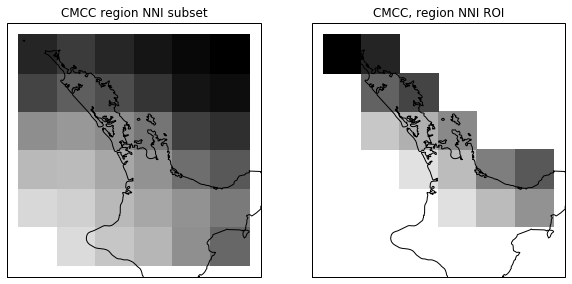

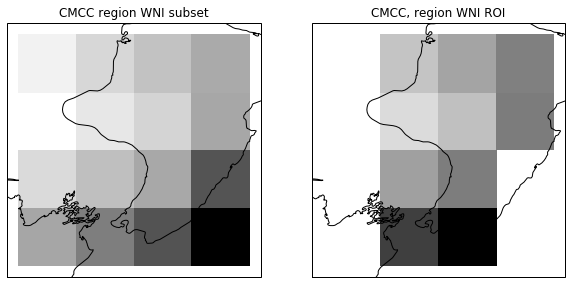

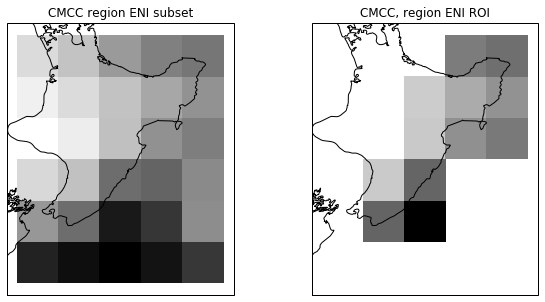

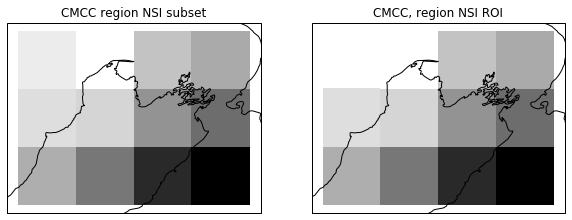

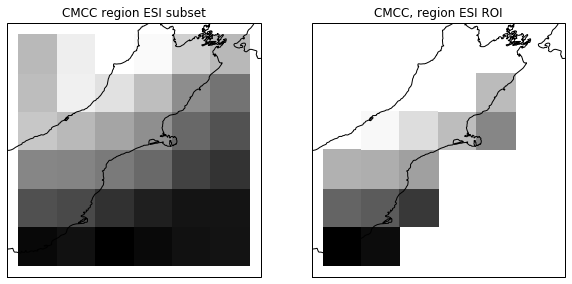

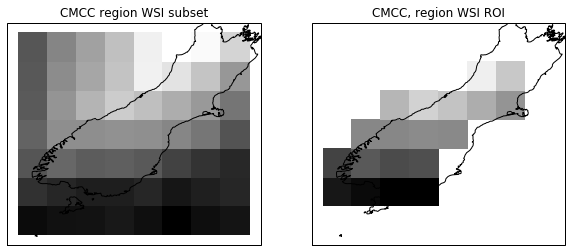

In [56]:
for region_name in nz_regions.Location.values:
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    f, axes = plt.subplots(figsize=(10, 5), ncols=2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}) 

    region = dset.salem.subset(shape=shape, margin=1)

    region[var_name.lower()][0,:,:].plot(ax=axes[0], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

    axes[0].coastlines(resolution='10m')

    axes[0].set_title(f'{GCM} region {region_name} subset')

    if ((region.dims['lat'] > 1) & (region.dims['lon'] > 1)):

        region = region.salem.roi(shape=shape, all_touched=True)

        region[var_name.lower()][0,:,:].plot(ax=axes[1], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

        axes[1].coastlines(resolution='10m')

        axes[1].set_title(f'{GCM}, region {region_name} ROI')

    f.savefig(CWD.parents[2] / 'figures' / f'subset_and_ROI_map_{GCM}_{region_name}.png', dpi=200, bbox_inches='tight')

### Now loops over the regions names, extract, calculate regional index and save to file 

In [57]:
quantiles_dict = {}

for region_name in nz_regions.Location.values: 
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    region = dset.salem.subset(shape=shape, margin=1)
    
    if ((region.dims['lat'] > 1) & (region.dims['lon'] > 1)):

        region = region.salem.roi(shape=shape, all_touched=True)
        
    else: 
        
        print(f"Warning: region {region_name} boundaries do not allow the ROI to be calculated")
        
    ts = region.mean(dim=['lat','lon'])
    
    ts_df = ts[var_name.lower()].to_dataframe()
            
    ts_series = ts_df.loc[:,var_name.lower()]
    
    ts_series_cat = []
    
    quantiles_list = []
    
    for month in range(1, 13):
        
        ts_series_m = ts_series[ts_series.index.month == month]
        
        clim = ts_series_m.loc['1993':'2016']
        
        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]
        
        quantiles_list.append(quantiles.copy())
        
        quantiles.insert(0, -np.inf)
        
        quantiles.append(np.inf)
        
        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))
        
        ts_series_cat.append(ts_series_m_cats)
        
        del(quantiles)
     
    quantiles_dict[region_name]  = np.array(quantiles_list)
    
    ts_series_cat = pd.concat(ts_series_cat, axis=0)
    
    ts_series_cat = ts_series_cat.sort_index()
    
    ts_df.loc[:,f'cat_{num_quantiles}'] = ts_series_cat
    
    ts_df.loc[:,'anomalies'] = ts_df.loc[:,var_name.lower()]
    
    ts_df = ts_df.loc[:,['month',f'cat_{num_quantiles}','anomalies']]
    
    opath = opath_root / region_name 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    ts_df.to_csv(opath / f'TS_NZ_region_{region_name}_{GCM}_{var_name}_{num_quantiles}_quantiles_anoms.csv')
    
    #descriptive statistics per quantile category 
    
    ts_df.groupby(ts_df.loc[:,f'cat_{num_quantiles}']).describe().to_csv(opath / f'descriptive_stats_{region_name}_{GCM}_{var_name}_{num_quantiles}.csv')
    
    print(f"region {region_name} processed for variable {var_name}")
    

region NNI processed for variable T2M
region WNI processed for variable T2M
region ENI processed for variable T2M
region NSI processed for variable T2M
region ESI processed for variable T2M
region WSI processed for variable T2M


In [58]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/CMCC/T2M/WSI')

### saves the climatological terciles calculated from the VCSN regional aggregates

In [59]:
quantiles_list = []
for region_name in nz_regions.Location.values: 
    df = pd.DataFrame(quantiles_dict[region_name])
    df.index = range(1, 13)
    df.index.name = 'season'
    df.columns = pd.MultiIndex.from_product([[region_name],col_labs])
    quantiles_list.append(df)

In [60]:
quantiles_df = pd.concat(quantiles_list, axis=1)

In [61]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_6_regions/CMCC/T2M/WSI')

In [62]:
quantiles_df.to_csv(opath.parent / f'Climatological_quantiles_{num_quantiles}_cat_{var_name}.csv')

In [63]:
quantiles_df

NNI                 WNI                 ENI                 NSI  \
             Q33       Q66       Q33       Q66       Q33       Q66       Q33   
season                                                                         
1      -0.072565  0.123443 -0.090336  0.150580 -0.113462  0.135904 -0.097852   
2      -0.115445  0.039733 -0.137377  0.094576 -0.113127  0.061532 -0.104371   
3      -0.184989  0.135070 -0.233230  0.175465 -0.148558  0.074554 -0.226887   
4      -0.094665  0.100971 -0.088160  0.039584 -0.074215  0.057996 -0.112186   
5      -0.204499 -0.130593 -0.204818 -0.147202 -0.185352 -0.052683 -0.230175   
6      -0.133122  0.097609 -0.148978  0.080495 -0.135789  0.089692 -0.127359   
7      -0.144687  0.079546 -0.171211  0.065496 -0.177706  0.080006 -0.145398   
8      -0.103549  0.168818 -0.142336  0.182758 -0.127693  0.175806 -0.116225   
9      -0.124340  0.080678 -0.152049  0.106982 -0.131157  0.046562 -0.137662   
10     -0.101070  0.085900 -0.120683  0.078421 -0.173045  0.046914 -0.073167   
11     -0.154744  0.156698 -0.127174  0.183373 -0.152481  0.137461 -0.097253   
12     -0.176030  0.220679 -0.225695  0.285404 -0.161518  0.200128 -0.211112   

                       ESI                 WSI            
             Q66       Q33       Q66       Q33       Q66  
season                                                    
1       0.172856 -0.092127  0.166709 -0.107542  0.202329  
2       0.102956 -0.116796  0.080193 -0.096370  0.113955  
3       0.147810 -0.181723  0.091089 -0.173854  0.116934  
4       0.072716 -0.113877  0.068122 -0.138988  0.069063  
5      -0.169444 -0.225201 -0.123515 -0.225674 -0.138643  
6       0.047625 -0.102159  0.057830 -0.141892  0.077216  
7       0.078995 -0.151617  0.036188 -0.156416  0.045293  
8       0.162408 -0.082623  0.098571 -0.112150  0.139194  
9       0.120266 -0.156214  0.127693 -0.140855  0.146149  
10      0.093080 -0.067325  0.115573 -0.042450  0.145106  
11      0.178847 -0.108247  0.123514 -0.055904  0.145117  
12      0.261601 -0.183488  0.238690 -0.212501  0.224001

### plots the anomalies and the categories 

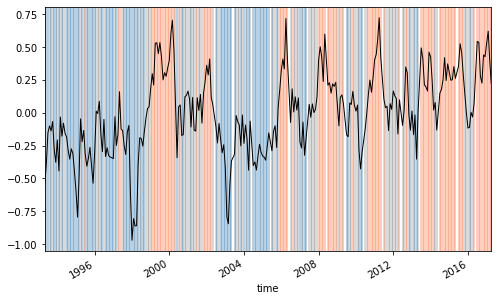

In [64]:
f, ax = plt.subplots(figsize=(8,5))
ts_df.anomalies.plot(lw=1, color='k', zorder=0)
cats = pd.to_numeric(ts_df.cat_3)
[ax.axvline(x, color='steelblue', alpha=0.5,lw=1.5, zorder=-10) for x in cats.loc[(cats == 1),].index];
[ax.axvline(x, color='k', alpha=0.2, lw=1.5, zorder=-10) for x in cats.loc[(cats == 2),].index];
[ax.axvline(x, color='coral', alpha=0.5,lw=1.5, zorder=-10) for x in cats.loc[(cats == 3),].index];
f.savefig('/home/nicolasf/Desktop/essai.png', dpi=200, bbox_inches='tight')

In [65]:
tmp_path

PosixPath('/home/nicolasf/data/tmp')

In [66]:
if remove_tmp: 
    shutil.rmtree(tmp_path)